In [1]:
# Import statements
from jupyter_plotly_dash import JupyterDash

import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
import plotly.graph_objs as go

import dash
from dash import dcc, html
from dash.dependencies import Input, Output

import folium
import pickle

In [2]:
# Loading the dataframe from a pickle file
with open('master_df.pickle', 'rb') as f:
    master_df = pickle.load(f)

# Creating a table of contents!
column_dict = {
    "Ungated Flow Cytometry Data": [],
    "Population 1 Flow Data (Inactive Neutrophils)": [],
    "Population 2 Flow Data (Activated Neutrophils)": [],
    "Population 3 Flow Data (Dead Neutrophils)": [],
    "Flow PMA": [],
    "Flow Unstim": [],
    "ROS assay Data": [],
    "Cell Count Data": [],
    "Cytokine Quantification Assay Data": [],
    "Biometric Data (Height, weight, etc.)": [],
    "Netosis Assay Data": []
}
# Define the start and end column for each category in a list of tuples
range_list = [
    ("1-Unstim-Cells-FoP", "2-PMA-Pop3-PMNs-Hmox1pos-Hmox1-MFI"),
    ("1-FoP", "2-%ROS-lo"),
    ("RBC", "Gra%"),
    ("CD163 (BR28) (28)", "TFR(BR13) (13)"),
    ("Initial_weight", "End_haem"),
    ("media_netosis", "nts_netosis")
]
# For each start and end column, get all column names in this range and store in the dictionary
for i, (start, end) in enumerate(range_list):
    start_idx = list(master_df.columns).index(start)
    end_idx = list(master_df.columns).index(end)

    if i == 0:  # The first range contains multiple categories
        column_dict["Ungated Flow Cytometry Data"] = [col for col in master_df.columns[start_idx : end_idx+1] if 'Pop' not in col]
        column_dict["Population 1 Flow Data (Inactive Neutrophils)"] = [col for col in master_df.columns[start_idx : end_idx+1] if 'Pop1' in col]
        column_dict["Population 2 Flow Data (Activated Neutrophils)"] = [col for col in master_df.columns[start_idx : end_idx+1] if 'Pop2' in col]
        column_dict["Population 3 Flow Data (Dead Neutrophils)"] = [col for col in master_df.columns[start_idx : end_idx+1] if 'Pop3' in col]
        column_dict["Flow PMA"] = [col for col in master_df.columns[start_idx : end_idx+1] if 'PMA' in col]
        column_dict["Flow Unstim"] = [col for col in master_df.columns[start_idx : end_idx+1] if 'Unstim' in col]

    else:  # All other ranges correspond to one category
        key = list(column_dict.keys())[i+3]  # Skip the first four keys
        column_dict[key] = [col for col in master_df.columns[start_idx : end_idx+1]]

label_colnames = [
    'geo_cluster',      # geographic clusters of samples
    'Group',             # one of three; Infected, Resolved, Control
    'Initial_RDT',       # initial rapid diagnostic malaria test (2nd visit)
    'Final_RDT',         # final rapid diagnostic malaria test (2nd visit)
    'Village',           # Village that patient lived in at time of sampling
    'Age',               # Age in years
    'Sex',               # male or female
    'killing_label',     # One of four; 'NonKiller', 'Killer-NonKiller', 'NonKiller-Killer', or 'Killer', based on Salmonella killing assay
    'days_after_start',   # days since start of sampling
    'visit_1_parasites_pa', # presence/absence of parasites on visit 1
    'visit_2_parasites_pa', # presence/absence of parasites on visit 2
    'ID', # Careful using this one to label clusters..!
    'RNAseq_done',
    'Netosis_responder'
]

label_to_display_map = {
    'geo_cluster': 'Geo Cluster',
    'Group': 'Infection Status',
    'Initial_RDT': 'Initial Malaria RDT',
    'Final_RDT': 'Final Malaria RDT',
    'Village': 'Village',
    'Age': 'Age',
    'Sex': 'Sex',
    'killing_label': 'Killing Assay Label',
    'days_after_start': 'Days Since Start',
    'visit_1_parasites_pa': 'Parasites at Start? (y/n)',
    'visit_2_parasites_pa': 'Parasites at End? (y/n)',
    'ID': 'Patient ID',
    'RNAseq_done': 'RNA-seq Data? (y/n)',
    'Netosis_responder': 'Netosis_responder'
}

In [5]:
column_dict

{'Ungated Flow Cytometry Data': ['1-Unstim-Cells-FoP',
  '1-Unstim-Singlets-FoP',
  '1-Unstim-CD15neg-FoP',
  '1-Unstim-PMNs-FoP',
  '1-Unstim-PMNs-Count',
  '1-Unstim-PMNs-CD16-MFI',
  '1-Unstim-PMNs-CD32-MFI',
  '1-Unstim-PMNs-CD15-MFI',
  '1-Unstim-PMNs-CD54-MFI',
  '1-Unstim-PMNs-CD63-MFI',
  '1-Unstim-PMNs-CD11b-MFI',
  '1-Unstim-PMNs-SScA-MFI',
  '1-Unstim-PMNs-CD10pos-FoP',
  '1-Unstim-PMNs-CD10pos-MFI',
  '1-Unstim-PMNs-CD10neg-FoP',
  '1-Unstim-PMNs-CD63pos-DL-FoP',
  '1-Unstim-PMNs-CD63pos-FoP',
  '1-Unstim-PMNs-CD63pos-MFI',
  '1-PMA-Cells-FoP',
  '1-PMA-Singlets-FoP',
  '1-PMA-CD15neg-FoP',
  '1-PMA-PMNs-FoP',
  '1-PMA-PMNs-Count',
  '1-PMA-PMNs-CD16-MFI',
  '1-PMA-PMNs-CD32-MFI',
  '1-PMA-PMNs-CD15-MFI',
  '1-PMA-PMNs-CD54-MFI',
  '1-PMA-PMNs-CD63-MFI',
  '1-PMA-PMNs-CD11b-MFI',
  '1-PMA-PMNs-SScA-MFI',
  '1-PMA-PMNs-CD10pos-FoP',
  '1-PMA-PMNs-CD10pos-MFI',
  '1-PMA-PMNs-CD10neg-FoP',
  '1-PMA-PMNs-CD63pos-DL-FoP',
  '1-PMA-PMNs-CD63pos-FoP',
  '1-PMA-PMNs-CD63pos-MFI',
 

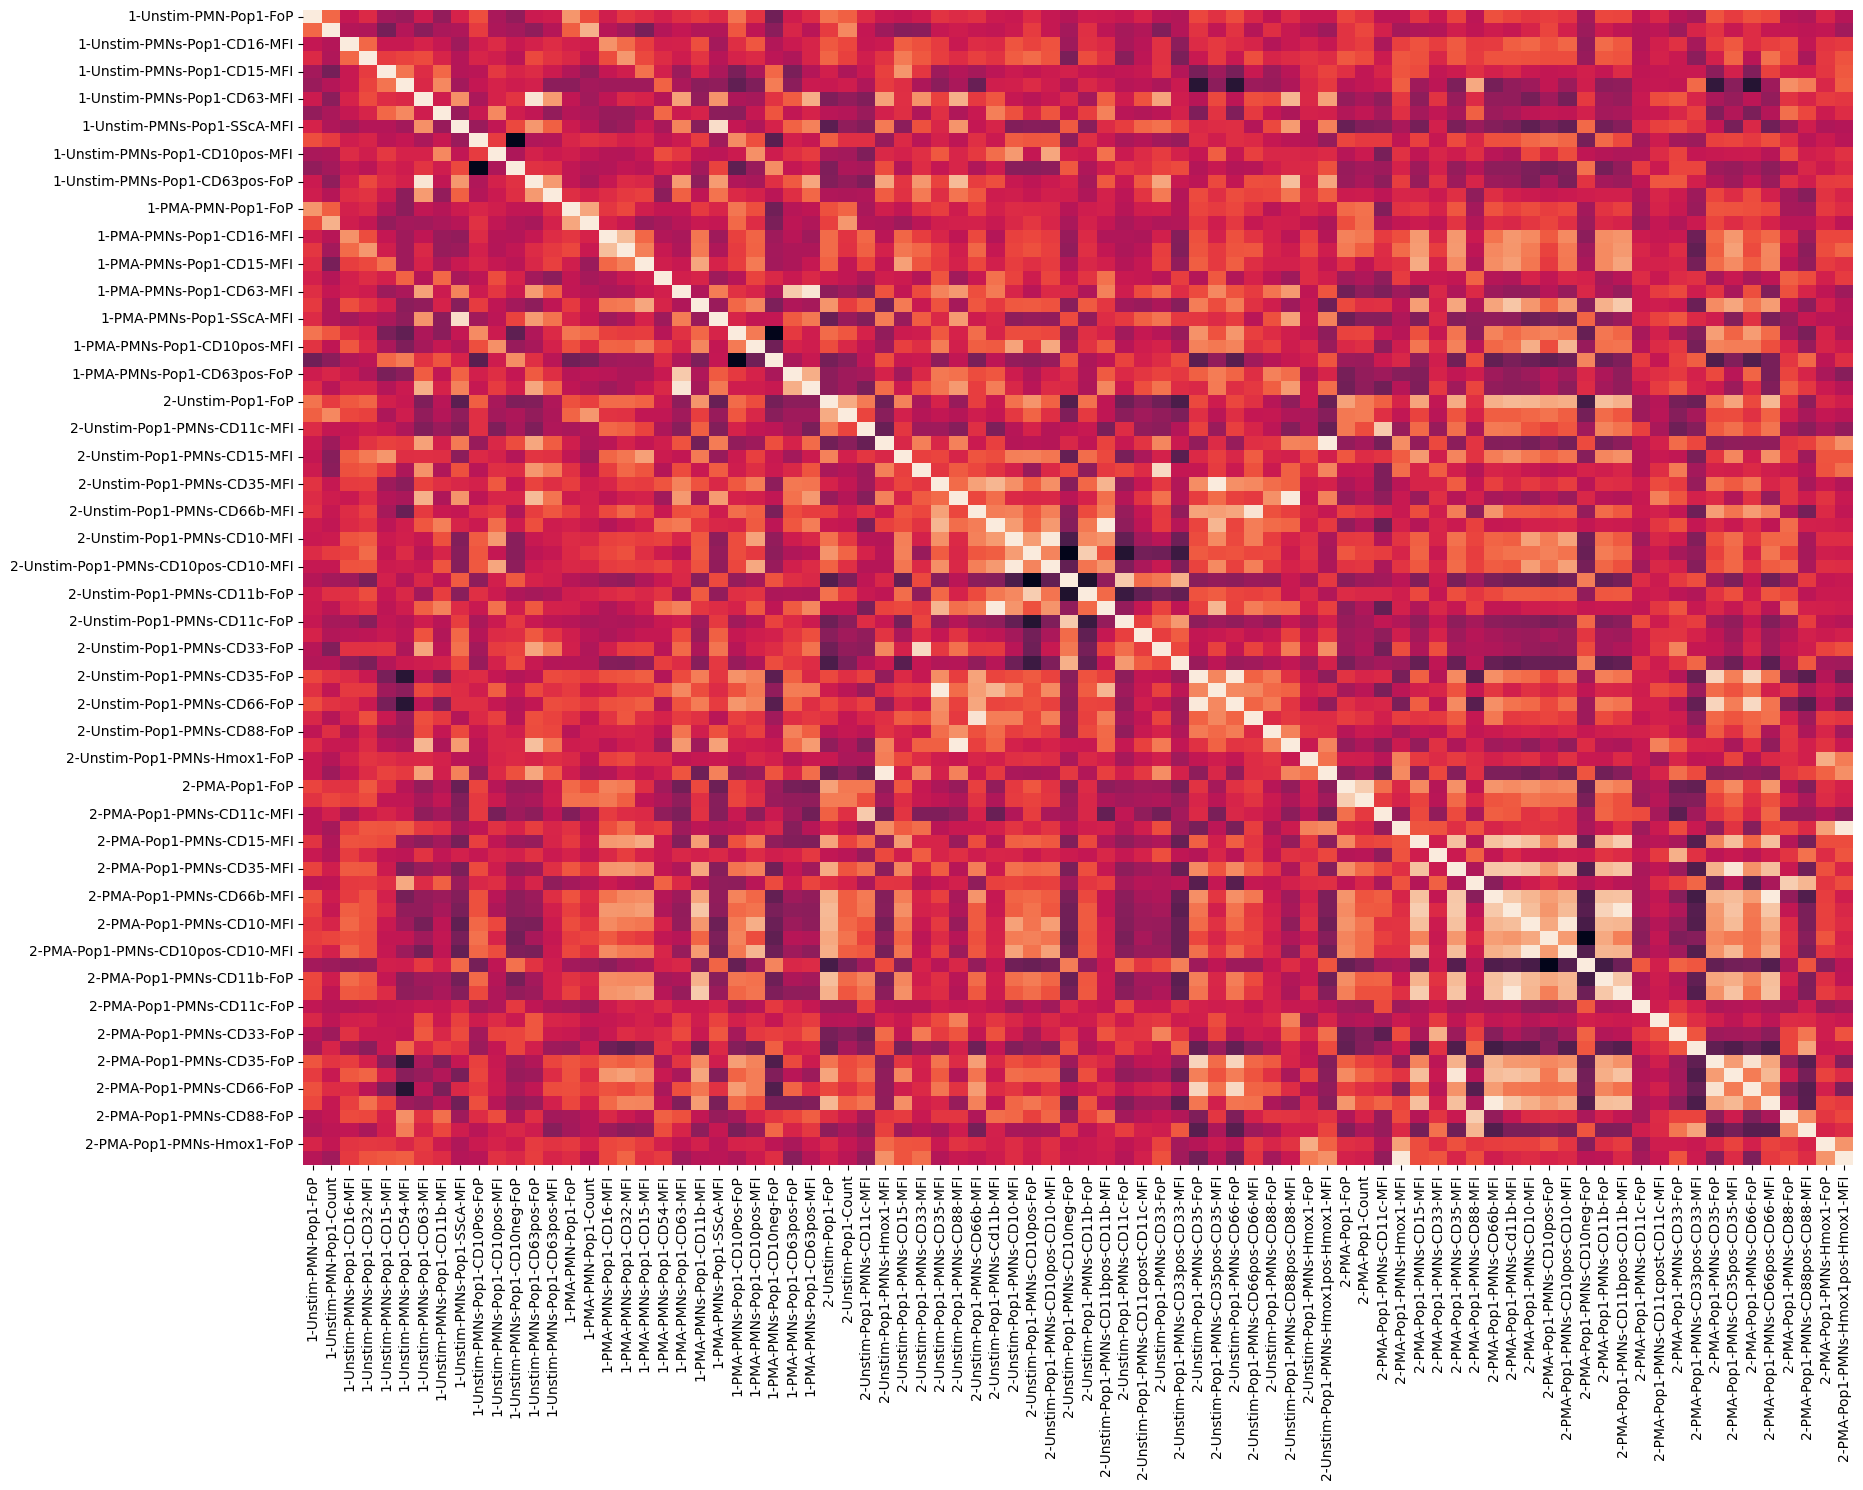

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = master_df[column_dict["Population 1 Flow Data (Inactive Neutrophils)"]].corr()
plt.figure(figsize=[20, 15])
sns.heatmap(correlation_matrix, annot=False, cbar=False)
plt.show()

In [ ]:
for i in master_df[column_dict["Population 1 Flow Data (Inactive Neutrophils)"]].columns:
    if i.startswith('2'):
        if 'CD66' in i:
            print(i)

pd.concat([master_df['2-Unstim-Pop1-PMNs-CD66pos-CD66-MFI'],
master_df['2-PMA-Pop1-PMNs-CD11cpost-CD11c-MFI'],
master_df['2-PMA-Pop1-PMNs-CD66pos-CD66-MFI']], axis=1)

In [3]:
'''
### Guide: ###

fetch column names (colnames) using "column_dict[key]"

fetch actual columns using master_df[colnames]

## keys: ##

"ungated_flc": Columns representing ungated flow cytometry data.gated 
"pop1_flc": Columns representing gated flow cytometry data for population 1 (inactivated(?)).
"pop2_flc": Columns representing gated flow cytometry data for population 2. (activated(?))
"pop3_flc": Columns representing gated flow cytometry data for population 3 (dead). 
"ROS": Columns representing reactive oxygen species (ROS) assay data.
"cell_count": Columns representing cell count data (RBC, granulocytes, plus some others).
"cytokine": Columns representing cytokine data.
"biometric": Columns representing biometric data, which includes weight, height, oxygen saturation and hemoglobin levels..
"netosis": Columns representing netosis data, a type of cell death specific to neutrophils. These are all columns from the sixth range.

You can add them together using '+' e.g.:

master_df[column_dict['pop1_flc'] + column_dict['pop2_flc']]


## Labels and hover data: ##

fetch label columns using master_df[<label_colname>]

label colnames are as follows:

'geo_cluster': geographic clusters of samples
'Group': one of three; Infected, Resolved, Control
'Initial_RDT': initial rapid diagnostic malaria test (2nd visit)
'Final_RDT': final rapid diagnostic malaria test (2nd visit)
'Village': Village that patient lived in at time of sampling
'Age': Age in years
'Sex': male or female
'killing_label': One of four; 'NonKiller', 'Killer-NonKiller', 'NonKiller-Killer', or 'Killer', based on Salmonella killing assay
'days_after_start': days since start of sampling

you can also iterate through them, they are stored in the list label_colnames

'''

'\n### Guide: ###\n\nfetch column names (colnames) using "column_dict[key]"\n\nfetch actual columns using master_df[colnames]\n\n## keys: ##\n\n"ungated_flc": Columns representing ungated flow cytometry data.gated \n"pop1_flc": Columns representing gated flow cytometry data for population 1 (inactivated(?)).\n"pop2_flc": Columns representing gated flow cytometry data for population 2. (activated(?))\n"pop3_flc": Columns representing gated flow cytometry data for population 3 (dead). \n"ROS": Columns representing reactive oxygen species (ROS) assay data.\n"cell_count": Columns representing cell count data (RBC, granulocytes, plus some others).\n"cytokine": Columns representing cytokine data.\n"biometric": Columns representing biometric data, which includes weight, height, oxygen saturation and hemoglobin levels..\n"netosis": Columns representing netosis data, a type of cell death specific to neutrophils. These are all columns from the sixth range.\n\nYou can add them together using \'+\

In [16]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [5]:
def create_geo_cluster_map(df, coord_col='coordinates', village_col='Village', cluster_col='geo_cluster'):

    # Create a map centered around the average coordinates
    avg_coords = df[coord_col].apply(pd.Series).mean().values.tolist()
    m = folium.Map(location=avg_coords, zoom_start=10, control_scale=True) # Add control_scale=True

    # Add a marker for every record in the DataFrame, use a different color for each cluster
    colors = ['red', 'blue', 'green', 'purple']

    for village, coord, cluster in zip(df[village_col], df[coord_col], df[cluster_col]):
        # Skip rows where 'geo_cluster' is NaN
        if pd.isna(cluster):
            continue
        folium.Marker(location=coord, 
                      icon=folium.Icon(color=colors[int(cluster)-1]), 
                      popup=f'{village}: Cluster {int(cluster)}').add_to(m)

    # Create a legend
    legend_html = '''
        <div style="position: fixed; 
                    top: 10px; left: 10px; min-width: 170px; min-height: 90px; 
                    border:2px solid grey; z-index:9999; font-size:14px;
                    background-color: white;
                    padding: 10px;
                    ">
            <b style="text-align: center; display: block;">Legend</b>
            <ul style="list-style-type: circle; padding-left: 20px; padding: 15px;">
                <li style="margin-bottom: 16px; font-size:15px">Cluster 1 <i class="fa fa-map-marker" style="font-size:22px; color:#e41a1c; float: right;"></i></li>
                <li style="margin-bottom: 16px; font-size:15px">Cluster 2 <i class="fa fa-map-marker" style="font-size:22px; color:#377eb8; float: right;"></i></li>
                <li style="margin-bottom: 16px; font-size:15px">Cluster 3 <i class="fa fa-map-marker" style="font-size:22px; color:#4daf4a; float: right;"></i></li>
                <li style="margin-bottom: 0px; font-size:15px">Cluster 4 <i class="fa fa-map-marker" style="font-size:22px; color:#984ea3; float: right;"></i></li>
            </ul>
        </div>
        ''' 


    # Add the legend to the map
    m.get_root().html.add_child(folium.Element(legend_html))

    return m


In [6]:
def performDR(features_cols, df, technique='umap'):

    df_filtered = df[df[features_cols].notnull().all(axis=1)]
    df_standardized = (df_filtered[features_cols] - df_filtered[features_cols].mean()) / df_filtered[features_cols].std()

    dr = {'pca': PCA(n_components=3), 'tsne': TSNE(n_components=3), 'umap': UMAP(n_components=3, n_neighbors=20, min_dist=0.6, spread=2)}[technique]
    dr_result = dr.fit_transform(df_standardized)
    dr_df = pd.DataFrame(data=dr_result, columns=['Component 1', 'Component 2', 'Component 3'])

    return dr_df

In [7]:
def createFigure(title, point_size, dr_df, master_df, features_cols, label_col, plot_3d=True, hover_data=None):

    # Removing NA values
    valid_rows = master_df[features_cols].notnull().all(axis=1)

    # Adding labels corresponding to remaining rows to a list
    labels = master_df[label_col][valid_rows].tolist()

    # Adding labels to the dimension reduction dataframe and resetting the index so the hover data works too
    dr_df['labels'] = labels
    dr_df = dr_df.reset_index(drop=True)


    if hover_data is not None:

        # Grabbing the hover data from the master df and resetting the indexes to align with dr_df (why am I using dr_df?)
        hover_df = master_df[hover_data][valid_rows]
        hover_df = hover_df.reset_index(drop=True)

    else:
        hover_df = None

    unique_labels = sorted(set(labels))

    fig = go.Figure()

    color_palette = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999']
    color_dict = {str(label): color_palette[i % len(color_palette)] for i, label in enumerate(unique_labels)}

    cumulative_indices = []

    for label in unique_labels:
        label_data = dr_df[dr_df['labels'] == label]
        for i in label_data.index:
            print(i)
        cumulative_indices.append([[i, label] for i in label_data.index])
        color = color_dict[str(label)]
        if hover_df is not None:
            hover_data_filtered = hover_df.loc[label_data.index]
            hovertemplate_parts = ["<br>".join([f"{col}: %{{customdata[{i}]}}" for i, col in enumerate(hover_data)])]
        else:
            hover_data_filtered = None
            hovertemplate_parts = []

        if plot_3d:
            fig.add_trace(go.Scatter3d(x=label_data['Component 1'], y=label_data['Component 2'], z=label_data['Component 3'],
                                       mode='markers', name=str(label),
                                       marker=dict(color=color, size=point_size),
                                       customdata=hover_data_filtered.values if hover_data_filtered is not None else [],
                                       hovertemplate=hovertemplate_parts[0] if hovertemplate_parts else ''))
            
            fig.update_layout(width=800, height=600, title=title, autosize=True)

        else:
            fig.add_trace(go.Scatter(x=label_data['Component 1'], y=label_data['Component 2'],
                                     mode='markers', name=str(label),
                                     marker=dict(color=color, size=point_size),
                                     customdata=hover_data_filtered.values if hover_data_filtered is not None else [],
                                     hovertemplate=hovertemplate_parts[0] if hovertemplate_parts else '',
                                     selectedpoints = [],
                                     selected = dict(marker = dict(color = 'orange')),
                                     unselected = dict(marker = dict(opacity = 0.9))))

            fig.update_layout(width=800, height=600, title=title, autosize=True, dragmode = 'select')
    for i in cumulative_indices:
        for j in i:
            print(j)
    return fig

In [8]:
desired_featurecols = column_dict["Flow PMA"]

plot_dataframe = performDR(column_dict["Flow PMA"], master_df)

In [14]:
for i in master_df.columns:
    print(i)

ID
Group
Parasites_uL_visit_1
visit_1_parasites_pa
Parasites_uL_visit_2
visit_2_parasites_pa
Date_visit_1
Date_visit_2
Age
Sex
Village
Initial_weight
End_weight
Initial_height
End_height
Initial_bodytemp
End_bodytemp
Initial_pulse
End_pulse
Initial_o2
End_o2
Initial_haem
End_haem
Initial_RDT
Final_RDT
RBC
MCV
HCT
MCH
MCHC
RDWR
PLT
MPV
HGB
WBC
Lym#
Mon#
Gra#
Lym%
Mon%
Gra%
CD163 (BR28) (28)
GROa KC (BR77) (77)
GCSF (BR54) (54)
IFNa (BR63) (63)
IL-1b/IL-1F2 (BR57) (57)
IL-6 (BR13) (13)
IL-10 (BR22) (22)
S100A9 (BR46) (46)
C5a (BR18) (18)
CXCL10/IP-10 (BR21) (21)
GM-CSF (BR66) (66)
IFNg (BR29) (29)
IL-4 (BR39) (39)
IL-8/CXCL8 (BR48) (48)
IL-12/IL-23p40 (BR67) (67)
TNFa (BR12) (12)
CRP(BR62) (62)
LBP(BR57) (57)
MPO(BR53) (53)
Ferritin(BR19) (19)
MMP-9(BR14) (14)
TFR(BR13) (13)
1-Unstim-Cells-FoP
1-Unstim-Singlets-FoP
1-Unstim-CD15neg-FoP
1-Unstim-PMNs-FoP
1-Unstim-PMNs-Count
1-Unstim-PMNs-CD16-MFI
1-Unstim-PMNs-CD32-MFI
1-Unstim-PMNs-CD15-MFI
1-Unstim-PMNs-CD54-MFI
1-Unstim-PMNs-CD63-MFI
1

In [15]:
plotted_figure = createFigure(plot_3d=False, label_col='geo_cluster', title = None, point_size = 3, dr_df = plot_dataframe, master_df = master_df, features_cols = desired_featurecols, hover_data=['ID', 'Sex', 'Village'])
plotted_figure

TypeError: boolean value of NA is ambiguous

In [109]:
create_geo_cluster_map(master_df)

In [ ]:
#Check y chromosome rna-seq against sex! DONE
#potentially check parasite var genes

In [ ]:
# Initialize the app
app = JupyterDash('UMAP')

# Define the layout
app.layout = html.Div([

    html.H1("UMAP dimensionality reduction of the AMAN (Asymptomatic Malaria, Anemia and Neutrophils) dataset", style={'textAlign': 'center'}),

    html.Div([  # Div for hover_cols
        html.Label('Hover Data: (optional)'),
        dcc.Checklist(id='hover_cols', options=[{'label': label_to_display_map[l], 'value': l} for l in label_colnames], value=[],
                      style={'float': 'left', 'width': '100%'})],
        style={'width': '13%', 'float': 'left'}
    ),

    html.Div([  # Div for features_cols and label_col
        
        html.Div([  # Div for plot_3d
            html.Label('Choose 2D/3D: (optional)'),
            dcc.Checklist(id='plot_3d', options=[{'label': '3D Plot', 'value': True}], value=[])],
            style={'width': '13%', 'float': 'left'}
        ),
        
        html.Div([  # Subdiv for features_cols
            html.Label('Feature selection:'),
            dcc.Dropdown(id='features_cols', options=[{'label': k, 'value': k} for k in column_dict.keys()], multi=True)],
            style={'width': '40%', 'float': 'left', 'margin-right': '20px'}
        ),
        html.Div([  # Div for update_button
            html.Button('Update Plot', id='update_button')],
            style={'float': 'left', 'margin-top': '25px', 'margin-right': '50px'}
        ),
        html.Div([  # Subdiv for label_col
            html.Label('Colour by:'),
            dcc.Dropdown(id='label_col', options=[{'label': label_to_display_map[l], 'value': l} for l in label_colnames], multi=False)],
            style={'width': '23%', 'float': 'left', 'margin-right': '40px'}
        ),

        html.Div([  # Div for dr_plot
            dcc.Graph(id='dr_plot', config={'displayModeBar': False}, style={'width': '100%', 'height': '100vh', 'margin': '0 auto'},
                    responsive=True)],
            style={'clear': 'both'}
        )
    ], style={'width': '70%', 'float': 'left', 'margin-bottom': '20px'}),  # Parent Div for features_cols and label_col

    html.Div([  # Div for point_size
        html.Label('Point Size:'),
        dcc.Slider(id='point_size', min=1, max=10, value=3, step=0.5, marks={i: str(i) for i in range(1, 11)})],
        style={'width': '40%', 'margin': '0 auto'}
    ),

    dcc.Store(id='intermediate_data'),  # the new Store component

    html.Div(id='selected-data',
             style={
                'position': 'fixed',
                'top': '0',
                'right': '0',
                'bottom': '0',
                'width': '150px',
                'padding': '20px',
                'overflow-y': 'auto'
            })

], style={'width': '100%'})


# Create the initial plot object
fig = go.Figure()

@app.callback(
    Output('intermediate_data', 'data'),
    [Input('features_cols', 'value'),
     Input('update_button', 'n_clicks')]
)
def update_intermediate_data(features_cols, n_clicks):
    if n_clicks is None:
        raise PreventUpdate

    cols = []
    for feature in features_cols:
        cols += column_dict[feature]

    plot_dataframe = performDR(cols, master_df)
    
    data = plot_dataframe.to_dict('records')
    
    # Store both the data and features_cols in the dcc.Store
    return {"data": data, "features_cols": cols}


@app.callback(
    Output('selected-data', 'children'),
    Input('dr_plot', 'selectedData')
)
def display_selected_data(selectedData):
    global curve_counts
    if selectedData is not None:
        curves = [point['curveNumber'] for point in selectedData['points']]
        points = [point['pointIndex'] for point in selectedData['points']]
        indices = []
        for curve, point in zip(curves, points):
            if curve == 0:
                indices.append(point)
            else:
                indices.append(curve_counts[curve - 1] + point)  # get the cumulative count from the previous curve and add the current point index
        selected_df = master_df.iloc[indices]
        id_list = selected_df['ID'].tolist()    
        return [html.P(f"ID: {str(id)}, {str(curve), str(point)}, {str(index)}") for id, curve, point, index in zip(id_list, curves, points, indices)]
    return []

@app.callback(
    Output('dr_plot', 'figure'),
    [Input('intermediate_data', 'data'),
     Input('label_col', 'value'),
     Input('hover_cols', 'value'),
     Input('point_size', 'value'),
     Input('plot_3d', 'value')]
)
def update_plot(intermediate_data, label_col, hover_cols, point_size, plot_3d):

    global fig
    global curve_counts

    if intermediate_data is None or label_col is None:
        return fig

    data = intermediate_data['data']  # Retrieve the data from intermediate_data
    features_cols = intermediate_data['features_cols']  # Retrieve the features_cols from intermediate_data

    plot_dataframe = pd.DataFrame(data)

    updated_fig= createFigure(plot_3d=plot_3d, label_col=label_col, title=None, point_size=point_size, dr_df=plot_dataframe, master_df=master_df, features_cols=features_cols, hover_data=hover_cols)
    fig = updated_fig


    return fig

app